## Data  and Moules

In [7]:
import numpy as np
import pandas as pd

In [6]:
#visoualization tools
from matplotlib import pyplot as plt, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from tqdm import tqdm

In [115]:
import statsmodels.api as sm
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [12]:
import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [18]:
os.environ['KAGGLE_USERNAME'] = 'dylankang0523'
os.environ['KAGGLE_KEY'] = 'c4fe36bc3052fe4ed3a8962d0926d213'

In [40]:
#!kaggle competitions download -c store-sales-time-series-forecasting

In [38]:
# from zipfile import ZipFile

In [39]:
# with ZipFile('store-sales-time-series-forecasting.zip', 'r') as zipObj:
#     zipObj.extractall()

-----

### Get train data

In [19]:
train = pd.read_csv('./data/train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                    usecols = ['date', 'store_nbr', 'family', 'sales'])

In [20]:
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date','store_nbr','family']).sort_index()

In [21]:
train.shape

(3000888, 1)

In [22]:
train.head()

sales
date       store_nbr family           
2013-01-01 1         AUTOMOTIVE    0.0
                     BABY CARE     0.0
                     BEAUTY        0.0
                     BEVERAGES     0.0
                     BOOKS         0.0

In [23]:
test = pd.read_csv('./data/test.csv',
                  parse_dates = ['date'], infer_datetime_format = True)

In [24]:
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date','store_nbr','family']).sort_index()

In [25]:
print(test.shape)
test.head()

(28512, 2)


id  onpromotion
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888            0
                     BABY CARE   3000889            0
                     BEAUTY      3000890            2
                     BEVERAGES   3000891           20
                     BOOKS       3000892            0

### oil price lag features

In [34]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')

In [28]:
oil = pd.read_csv('./data/oil.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')

In [30]:
oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [32]:
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()

In [35]:
calendar = calendar.join(oil.avg_oil)

In [36]:
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)

In [37]:
calendar.dropna(inplace = True)

In [38]:
calendar.tail()

,avg_oil
2017-08-27,47.720000
2017-08-28,47.624286
2017-08-29,47.320000
2017-08-30,47.115714
2017-08-31,47.060000


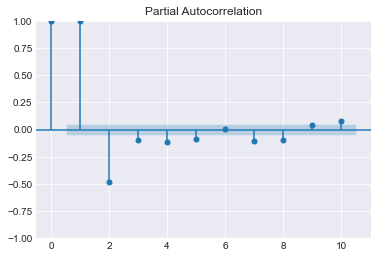

In [39]:
_ = plot_pacf(calendar.avg_oil, lags = 10)

In [44]:
n_lags = 3
for l in range(1, n_lags + 1):
    calendar[f'oil_lags{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)

In [45]:
calendar.head()

,avg_oil,oil_lags1,oil_lags2,oil_lags3
2013-01-13,93.284286,93.284286,93.284286,93.218571
2013-01-14,93.470000,93.284286,93.284286,93.284286
2013-01-15,93.490000,93.470000,93.284286,93.284286
2013-01-16,93.644286,93.490000,93.470000,93.284286
2013-01-17,93.970000,93.644286,93.490000,93.470000


### Holiday features

In [46]:
hol = pd.read_csv('./data/holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')

In [47]:
hol.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [51]:
hol = hol.loc[hol['locale'] == 'National']

In [53]:
hol = hol.groupby(hol.index).first() # remove duplicated holidays
print(hol.shape)

(168, 5)


In [54]:
hol.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


In [55]:
calendar = calendar.join(hol) # Joining calendar with holiday dataset

In [56]:
calendar.head()

,avg_oil,oil_lags1,oil_lags2,oil_lags3,type,locale,locale_name,description,transferred
2013-01-13,93.284286,93.284286,93.284286,93.218571,NaN,NaN,NaN,NaN,NaN
2013-01-14,93.470000,93.284286,93.284286,93.284286,NaN,NaN,NaN,NaN,NaN
2013-01-15,93.490000,93.470000,93.284286,93.284286,NaN,NaN,NaN,NaN,NaN
2013-01-16,93.644286,93.490000,93.470000,93.284286,NaN,NaN,NaN,NaN,NaN
2013-01-17,93.970000,93.644286,93.490000,93.470000,NaN,NaN,NaN,NaN,NaN


In [57]:
calendar['dofw'] = calendar.index.dayofweek
calendar['wd'] = 1

In [58]:
calendar.head()

,avg_oil,oil_lags1,oil_lags2,oil_lags3,type,locale,locale_name,description,transferred,dofw,wd
2013-01-13,93.284286,93.284286,93.284286,93.218571,NaN,NaN,NaN,NaN,NaN,6,1
2013-01-14,93.470000,93.284286,93.284286,93.284286,NaN,NaN,NaN,NaN,NaN,0,1
2013-01-15,93.490000,93.470000,93.284286,93.284286,NaN,NaN,NaN,NaN,NaN,1,1
2013-01-16,93.644286,93.490000,93.470000,93.284286,NaN,NaN,NaN,NaN,NaN,2,1
2013-01-17,93.970000,93.644286,93.490000,93.470000,NaN,NaN,NaN,NaN,NaN,3,1


In [60]:
calendar.loc[calendar.dofw > 4, 'wd'] = 0  # remove saturday or sunday

In [61]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1692 entries, 2013-01-13 to 2017-08-31
Freq: D
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   avg_oil      1692 non-null   float64
 1   oil_lags1    1692 non-null   float64
 2   oil_lags2    1692 non-null   float64
 3   oil_lags3    1692 non-null   float64
 4   type         144 non-null    object 
 5   locale       144 non-null    object 
 6   locale_name  144 non-null    object 
 7   description  144 non-null    object 
 8   transferred  144 non-null    object 
 9   dofw         1692 non-null   int64  
 10  wd           1692 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 223.2+ KB


In [62]:
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 

In [70]:
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1

In [72]:
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True)

In [73]:
calendar = pd.get_dummies(calendar, columns = ['type'])

In [74]:
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True)

In [75]:
print(calendar.shape)
calendar.head()

(1692, 17)


,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0


### Time dependent features

In [77]:
calendar['wageday']=0
calendar.loc[(calendar.index.to_timestamp().is_month_end) | (calendar.index.day == 15), 'wageday'] = 1

In [78]:
calendar.head()

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,wageday
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0,0


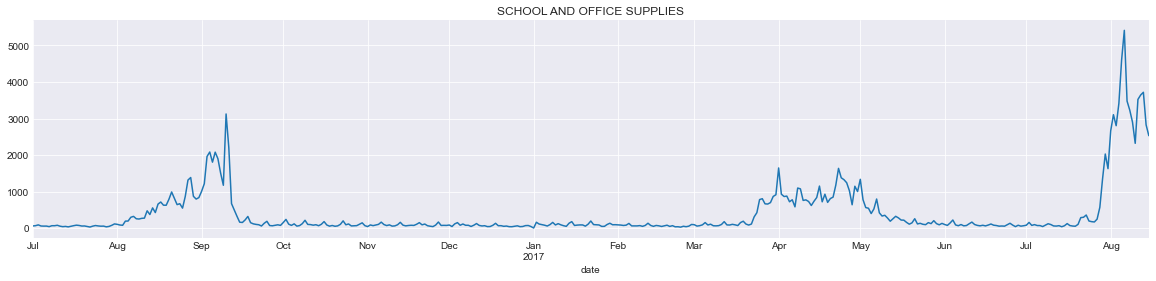

In [80]:
ax = plt.subplots(1,1,figsize = (20,4))
train.loc["2016-07-01":].filter(like = 'SCHOOL AND OFFICE SUPPLIES', axis=0).groupby(["date"])['sales'].sum().plot(title = "SCHOOL AND OFFICE SUPPLIES")
plt.show()

In [81]:
school_season = []
for i, r in calendar.iterrows():
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season

### Zero forecasting

In [82]:
c = train.groupby(["store_nbr","family"]).tail(15).groupby(["store_nbr","family"])['sales'].sum().reset_index()

In [83]:
c = c[c['sales'] == 0].drop('sales', axis = 1)

In [84]:
c = c[c.family != "SCHOOL AND OFFICE SUPPLIES"]

In [85]:
c.shape

(124, 2)

In [86]:
c.head()

,store_nbr,family
1,1,BABY CARE
4,1,BOOKS
17,1,HOME APPLIANCES
34,10,BABY CARE
37,10,BOOKS


In [87]:
print("Shape of train before zero forecasting:", train.shape)

Shape of train before zero forecasting: (3000888, 1)


In [89]:
outer_join = train.reset_index().merge(c, how = 'outer', indicator = True)

In [90]:
train = outer_join[~(outer_join['_merge'] == 'both')].drop('_merge', axis = 1) # anti join

In [91]:
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()

In [92]:
del outer_join

In [93]:
gc.collect()
print("Shape of train after zero forecasting:", train.shape)

Shape of train after zero forecasting: (2792072, 1)


In [95]:
zero_prediction = []

for i in range(0, len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )

In [96]:
zero_prediction = pd.concat(zero_prediction)

In [97]:
zero_prediction.head()

,date,store_nbr,family,sales
0,2017-08-16,1,BABY CARE,0
1,2017-08-17,1,BABY CARE,0
2,2017-08-18,1,BABY CARE,0
3,2017-08-19,1,BABY CARE,0
4,2017-08-20,1,BABY CARE,0


In [98]:
zero_prediction['date'] = zero_prediction.date.dt.to_period('D')

In [99]:
del c

In [100]:
gc.collect()

42

In [101]:
zero_prediction = zero_prediction.set_index(['date', 'store_nbr', 'family'])
zero_prediction.head()

,,,sales
date,store_nbr,family,
2017-08-16,1,BABY CARE,0
2017-08-17,1,BABY CARE,0
2017-08-18,1,BABY CARE,0
2017-08-19,1,BABY CARE,0
2017-08-20,1,BABY CARE,0


In [102]:
zero_prediction

,,,sales
date,store_nbr,family,
2017-08-16,1,BABY CARE,0
2017-08-17,1,BABY CARE,0
2017-08-18,1,BABY CARE,0
2017-08-19,1,BABY CARE,0
2017-08-20,1,BABY CARE,0
...,...,...,...
2017-08-27,9,HOME APPLIANCES,0
2017-08-28,9,HOME APPLIANCES,0
2017-08-29,9,HOME APPLIANCES,0


In [109]:
a = train.groupby(["date","store_nbr"]).sum().reset_index()

In [110]:
a = a[a["sales"] > 0].groupby("store_nbr")[["date"]].min().sort_values(by="date",ascending = False).head(5)

In [111]:
a.head()

,date
store_nbr,
52,2017-04-20
22,2015-10-09
42,2015-08-21
21,2015-07-24
29,2015-03-20


In [112]:
y = train.unstack(['store_nbr', 'family']).loc["2017-04-21":]

In [116]:
fourier = CalendarFourier(freq = 'W', order = 3)

In [117]:
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)

In [118]:
x = dp.in_sample()

In [120]:
x = x.join(calendar)
x.index.name = "date"

In [122]:
xtest = dp.out_of_sample(steps = 16) 
xtest = xtest.join(calendar)
xtest.index.name = "date"

In [123]:
del hol
del calendar
del dp
del oil
_ = gc.collect()

## Quick analysis of Multivariate TSD